In [5]:
import torch
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import random_split
from dataset_utils import create_dataset
import torch.nn as nn
import torch.optim as optim

import json

import argparse

import datasets.utils as dataHelper

from networks import openSetClassifier

from utils import progress_bar

import os
import numpy as np

transform = v2.Compose(
    [
        v2.Grayscale(num_output_channels=3),
        v2.RandomAffine(degrees=(0, 180), translate=(0, 0.1), scale=(0.95, 1.05), fill=255),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
    ]
)


from torchvision.models import resnet18, densenet121
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#parameters useful when resuming and finetuning
best_acc = 0
best_cac = 10000
best_anchor = 10000
start_epoch = 0
dataset = "PLANKTON"
backbone = "resnet"

#Create dataloaders for training
print('==> Preparing data..')
with open('datasets/config.json') as config_file:
	cfg = json.load(config_file)[dataset]

# Define path
path = "./main_dataset"
trial = 0

# Dataset id for open-set test set
test_idx = [3 * (trial), 3 * (trial) + 1, 3 * (trial) + 2]

train_dataset, test_dataset = create_dataset(path, transform, test_idx=test_idx)

# Split the dataset to training and validation and further split the validation to also testing
training_set, validation_set = random_split(train_dataset, [0.8, 0.2])

batch_size = cfg["batch_size"]
trainloader = DataLoader(training_set, batch_size=batch_size, shuffle=True)
valloader = DataLoader(validation_set, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

mapping = [i for i in range(cfg["num_classes"])]

print('==> Building network..')
backbone = "densenet"
net = openSetClassifier.openSetClassifier(cfg['num_known_classes'], cfg['im_channels'], cfg['im_size'], dropout = cfg['dropout'], backbone = backbone)
net = net.to(device)

net.train()
optimizer = optim.SGD(net.parameters(), lr = cfg['openset_training']['learning_rate'][0], 
							momentum = 0.9, weight_decay = cfg['openset_training']['weight_decay'])



def CACLoss(distances, gt):
	'''Returns CAC loss, as well as the Anchor and Tuplet loss components separately for visualisation.'''
	true = torch.gather(distances, 1, gt.view(-1, 1)).view(-1)
	non_gt = torch.Tensor([[i for i in range(cfg['num_known_classes']) if gt[x] != i] for x in range(len(distances))]).long().cuda()
	others = torch.gather(distances, 1, non_gt)
	
	anchor = torch.mean(true)

	tuplet = torch.exp(-others+true.unsqueeze(1))
	tuplet = torch.mean(torch.log(1+torch.sum(tuplet, dim = 1)))

	total = 0.1*anchor + tuplet

	return total, anchor, tuplet



# Training
def train(epoch):
	print('\nEpoch: %d' % epoch)
	net.train()
	train_loss = 0
	correctDist = 0
	total = 0

	for batch_idx, (inputs, targets) in enumerate(trainloader):
		inputs, targets = inputs.to(device), targets.to(device)
		#convert from original dataset label to known class label
		targets = torch.Tensor(targets).long().to(device)

		optimizer.zero_grad()

		outputs = net(inputs)
		cacLoss, anchorLoss, tupletLoss = CACLoss(outputs[1], targets)

		cacLoss.backward()

		optimizer.step()

		train_loss += cacLoss.item()

		_, predicted = outputs[1].min(1)

		total += targets.size(0)
		correctDist += predicted.eq(targets).sum().item()

		progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
			% (train_loss/(batch_idx+1), 100.*correctDist/total, correctDist, total))
  
max_epoch = cfg['openset_training']['max_epoch'][0]+start_epoch
for epoch in range(start_epoch, max_epoch):
	train(epoch)


==> Preparing data..
==> Building network..

Epoch: 0


NameError: name 'optimizer' is not defined

## 
x = distances

y = correct labels

In [26]:
num_train_classes = len(train_dataset.classes)
import sklearn.metrics
def auroc_th(x, y, num_train_classes, in_low = True):

 
	allData = np.concatenate((inData, outData))
	labels = np.concatenate((np.zeros(len(inData)), np.ones(len(outData))))
	fpr, tpr, thresholds = sklearn.metrics.roc_curve(labels, allData, pos_label = in_low)

	return sklearn.metrics.auc(fpr, tpr)

auroc_th(y_pred, y_corr, len(train_dataset.classes))

0.8043326666666667

In [31]:
def get_mask(y, num_train_classes):
	mask_known = y < num_train_classes
	mask_unk = y >= num_train_classes
	return mask_known, mask_unk



In [40]:
def process_values(x, y):
    # Get mask for known and unknown classes
    mask_known, mask_unk = get_mask(y, num_train_classes)
    threshold = 2
    # Change every unknown class to same class
    y[mask_unk] = 12
    predicted = np.argmin(x, axis=1)
    predicted[np.min(x, axis=1) > threshold] = num_train_classes
    
    return (np.array(predicted), np.array(new_y))




x_known = x[mask_known]
print(x_known.shape)


(6000, 12)


In [8]:
for i in range(0, 10):
    print(f"Pred: {y_pred[i]}, correct: {y_corr[i]}")
    # print(y[i])

Pred: 12, correct: 12
Pred: 8, correct: 8
Pred: 8, correct: 12
Pred: 5, correct: 5
Pred: 3, correct: 3
Pred: 11, correct: 11
Pred: 11, correct: 11
Pred: 9, correct: 12
Pred: 7, correct: 7
Pred: 1, correct: 1


In [9]:
def create_conf_matrix(labels, predictions):
    
    # Confusion matrix
    rows = len(set(labels))
    cols = len(set(predictions))
    conf_matrix = np.zeros((rows, cols), dtype=int)

    # Fill in the confusion matrix based on true labels and predictions
    for true_label, pred_label in zip(labels, predictions):
        conf_matrix[true_label, pred_label] += 1

    return conf_matrix


Known classes=0.8213, Unknown classes=0.5960


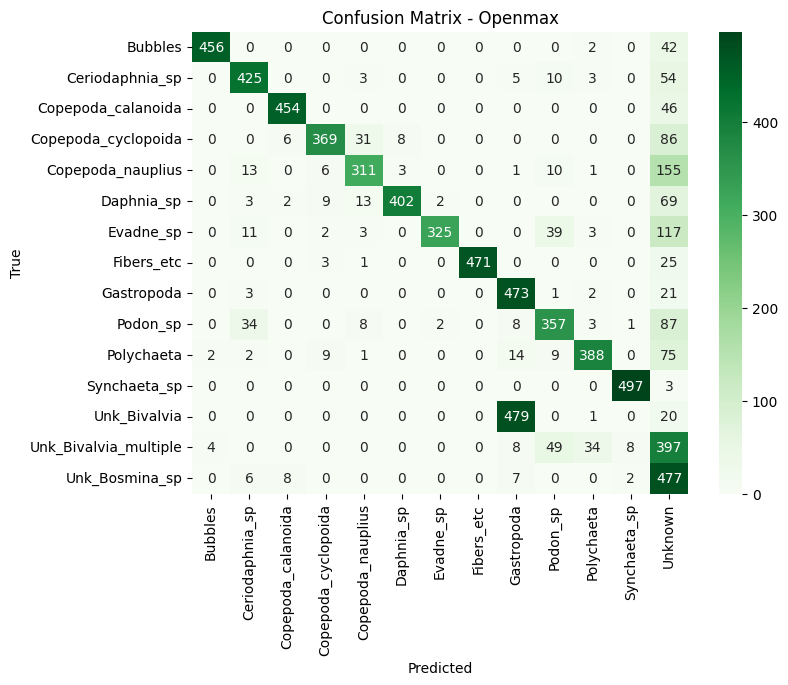

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
# Confusion matrix
conf_matrix = create_conf_matrix(y, y_pred)
xticklabels = train_dataset.classes + ["Unknown"]

# Plot confusion matrix
calc_accuracies(y_corr, y_pred, len(train_dataset.classes))
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=xticklabels, yticklabels=test_dataset.classes)
plt.title('Confusion Matrix - Openmax')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Test different threshold values

In [7]:
best_acc = 0
best_th = 0
for th in range(200,500):
    threshold = th/100
    predicted = []
    for idx, array in enumerate(x):

        if np.min(array) > threshold:
            pred = 12
        else:
            pred = np.argmin(array)

        predicted.append(pred)
    total = len(new_y)
    acc = np.sum(predicted == new_y)/total
    if acc > best_acc:
        best_th = threshold
        best_acc = acc

print(best_acc)
print(best_th)

0.7988
2.7


In [8]:
import open_clip
model, preprocess_train, preprocess_val = open_clip.create_model_and_transforms('hf-hub:imageomics/bioclip', jit=False)

<bound method CLIP.encode_image of CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-11): 12 x ResidualAttentionBlock(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((7